In [674]:
import numpy as np
from numpy.linalg import inv as inv
from scipy.linalg import solve_continuous_are
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
import cvxpy as cp
import time
import scipy.optimize as opt

DIM = 1

In [675]:
# Computer K and P_t-1 for standard LQR controller
def lqr(A, B, Q, R, P):
    K = -1 * inv(B.T @ P @ B + R) @ B.T @ P @ A
    Ptm1 = A.T @ P @ A + (B.T @ P @ A).T @ K + Q
    return K, Ptm1

# Compute terms when we are trying to be robust to estimation error
def dist_lqr(A, B, Q, R, S, P):
    I = np.eye(DIM)
    G = inv(Q + A.T@P@A - S)@A@P
    M = inv(Q + A.T@P@A - S)@(Q + A.T@P@A)
    Qp = G.T@Q@G + (I-A@G).T@P@(I-A@G)
    Ap = I - M
    Qpp = G.T@Q - (I-A@G).T@P@A
    
    K = inv(B.T@Qp@B + R) @ B.T@Qpp@Ap 
    Ptm1 = (Ap-G@B@K).T@Q@(Ap-G@M@K) + K.T@R@K + ((A-A@M)-(I-A@G)@B@K).T@P@((A-A@M)-(I-A@G)@B@K)
    
    return K, Ptm1
    
# def get_opt_dist_uPOV(xhat, K, A, B, Q, R, S, P):
#     dist = inv(Q + A.T@P@A - S) @ (A.T@P@B@K + (Q + A.T@Q@A))@xhat

def get_opt_dist_distPOV(x, K, A, B, Q, R, S, P, d_max):
    if d_max == 0: return 0
    # helping...?
    dist = - inv(K.T@R@K + K.T@B.T@P@B@K - S) @ (K.T@R@K + K.T@B.T@P@(A+B@K)) @ x
    return dist
    
def get_opt_dist_SDP(x, K, A, B, Q, R, S, P, d_max):
    if d_max == 0: return 0
    
    M = K.T@R@K + K.T@B.T@P@K@B - S
    q = 2*(K.T@R@K + K.T@B.T@P@(A + B@K))@x
    r = x.T@(Q + K.T@R@K + (A + B@K).T@P@(A + B@K))@x
    # print(r)
    loss = lambda d: -1* (d.T@M@d + d.T@q + r)
    fun = lambda d: - d.T@M@d - d.T@q - r[0][0]
    d0 = np.zeros(x.shape)+0.01
    
    res = opt.minimize(fun, x0=d0)
#     print(res)
#     print(res.x)
#     print(get_opt_dist_distPOV(x, K, A, B, Q, R, S, P, d_max))
    
    return res.x@x
#     Q0 = np.block([[M, q],[q.T, r]])
#     t = cp.Variable()
#     T = np.block([[np.zeros(S.shape),np.zeros(q.shape)],[np.zeros(q.T.shape),1]])
    
#     opt = cp.Minimize(t)
#     c1 = Q0 << t*T
#     prob = cp.Problem(opt, [c1])
#     prob.solve()
#     t = t.value
    

    t = loss(np.zeros(x.shape), M, q, r)
    print(t)
    d1 = 2*inv(M)*(-1*q + np.sqrt(q**2 - 4*M*(r-t)))
    d2 = 2*inv(M)*(-1*q + np.sqrt(q**2 - 4*M*(r-t)))
    print(d1)
    print(d2)
#     d = - inv(K.T@R@K + K.T@B.T@P@B@K - S) @ (K.T@R@K + K.T@B.T@P@(A+B@K)) @ x
#     print()
    return 0

In [676]:
# Loss
J_lqr = lambda x,u,A,B,Q,R,P: (x.T@Q@x + u.T@R@u + (A@x + B@u).T@P@(A@x + B@u))[0][0]

# Standard LQR with disturbance
def run_lqr(x, A, B, Q, R, S, n_steps=5, d_max=1, noise=None, method='standard',seed=None):
    if seed is not None:
        np.random.seed(seed)
    '''
    x: starting position
    S: paramterization of ellipse, S is PD
    d_max: disturbance within a ball of radius d_max 
    '''
    # Compute P_t for each t assuming P_T = Q
    Ps = [Q]
    Ps_o = [Q]
    for i in range(n_steps-1):
        K, Ptm1 = lqr(A, B, Q, R, Ps[-1])
        K_o, Ptm1_o = dist_lqr(A, B, Q, R, S, Ps_o[-1])
        Ps.append(Ptm1)
        Ps_o.append(Ptm1_o)
            
    # flip around so P[t] = P_t
    Ps = Ps[::-1] 
    Ps_o = Ps_o[::-1] 
    cost = []
    d = 0
    for i in range(n_steps):
        P = Ps[i]
        P_o = Ps_o[i]
        K, _ = lqr(A, B, Q, R, P)
        K_o, _ = dist_lqr(A, B, Q, R, S, P_o)

        if noise is None:
            d = 0
        elif noise == 'random':
            d = 2*d_max*(np.random.random(x.shape) - 0.5)
        elif noise == 'standard':
            d = get_opt_dist_SDP(x, K, A, B, Q, R, S, P, d_max)
            print(d)
        elif noise == 'robust_to_est_error':
            d = get_opt_dist_SDP(x, K_o, A, B, Q, R, S, P_o, d_max)
        
        
        xhat = x + d 
        if method == 'standard':
            u = K@xhat
            cost.append(J_lqr(x,u,A,B,Q,R,P))
        elif method == 'robust_to_est_error':
            u = K_o@xhat
            cost.append(J_lqr(x,u,A,B,Q,R,P_o))

        x = A@x + B@u

    return cost

In [677]:
Q = np.eye(DIM)
R = np.eye(DIM) 
# A = np.random.normal(0,1,(DIM,DIM))
# B = np.random.normal(0,1,(DIM,DIM))

# A = np.array([[ 0.09114661,  0.2488551 ], [-2.04227927, -0.72706596]])
# B = np.array([[-0.03184335,  0.39405137], [-0.57855091, -0.25887833]])


[1.03400208]
[-0.26582252]
[0.06833634]
[-0.01756501]
[0.00451035]
[-0.00115023]
[0.00027956]
[-4.63302771e-05]
[-2.7752773e-14]
[-1.11007447e-14]
[1.03400208]
[0.15360217]
[0.02009114]
[0.0029966]
[0.0003899]
[5.82429633e-05]
[7.41242748e-06]
[9.1645026e-07]
[-2.5045583e-15]
[-1.45939911e-15]


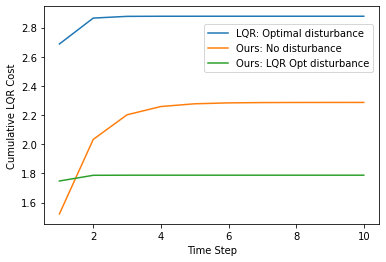

In [709]:
S = np.eye(DIM)*.95
S_o = S

# Starting position, goal at 0
A = np.array([[1]])
B = np.array([[1]])
x = [[1]] # ,[1]] # ,[1],[1],[1]]
# LQR disturbance, max norm -> find sigma for 
n_steps = 10
d_max = 0.5 # Maximum disturbance
d_max_opt = 0.5# .1245
# Standard LQR, d_max = 0
no_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=0, noise=None, method='standard')
# Standard LQR with optimal estimation error, d_max = d_max
opt_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, noise='standard', method='standard')
# Standard LQR with random estimation error, d_max = d_max
rnd_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max, noise='random', method='standard')

# Our thing 
no_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S_o, n_steps=n_steps, d_max=0, noise=None, method='robust_to_est_error')
# Our thing
opt_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S_o, n_steps=n_steps, d_max=d_max_opt, noise='robust_to_est_error', method='robust_to_est_error')
# Our thing
rnd_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S_o, n_steps=n_steps, d_max=d_max_opt, noise='random', method='robust_to_est_error')

lqr_dist_y_opt = run_lqr(np.array(x), A, B, Q, R, S_o, n_steps=n_steps, d_max=d_max_opt, noise='standard', method='robust_to_est_error')

# opt_dist_y_lqr = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max_opt, noise='robust_to_est_error', method='standard')


x = [i for i in range(1,n_steps+1)]

# plt.figure()
# plt.plot(x, np.cumsum(no_dist_y), label="LQR: No disturbance")
plt.plot(x, np.cumsum(opt_dist_y), label="LQR: Optimal disturbance")
# plt.plot(x, np.cumsum(rnd_dist_y), label="LQR: Random disturbance")
plt.plot(x, np.cumsum(no_dist_y_opt), label="Ours: No disturbance")
# plt.plot(x, np.cumsum(opt_dist_y_opt), label="Ours: Optimal disturbance")
# plt.plot(x, np.cumsum(rnd_dist_y_opt), label="Ours: Random disturbance")
plt.ylabel("Cumulative LQR Cost")
plt.xlabel("Time Step")
plt.plot(x, np.cumsum(lqr_dist_y_opt), label="Ours: LQR Opt disturbance")


# plt.plot(x, np.cumsum(opt_dist_y_lqr), label="LQR: Our Opt disturbance") # not super informative

plt.legend(loc='upper center', bbox_to_anchor=(0.73,0.94))
plt.show()

In [680]:
# optimization not loss 

# get a game, game is not trivial
# control uses dist, dist uses control